In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 3
despine_trim = True

### look at the distribution of RepliSeq values when binned at a given bin size

Since this is a wavelet-smoothed signal, I expect the distributions to be the same at each bin size but I just want to confirm that this is true.

Higher RepliSeq values correspond to earlier replication timing of the region. For a full description of the methods used see [this website](https://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg19&g=wgEncodeUwRepliSeq#TRACK_HTML).

In [3]:
rt_bins = pd.read_csv('../../data/gc_rt_bins.csv')
rt_bins.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Chromosome,Start,End,gc,mcf7_rt,bg02es_rt,bj_rt,gm06990_rt,gm12801_rt,gm12812_rt,gm12813_rt,gm12878_rt,helas3_rt,hepg2_rt,huvec_rt,imr90_rt,k562_rt,sknsh_rt,nhek_rt,bin_size
0,1,0,5000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000
1,1,5000,10000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000
2,1,10000,15000,0.5894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000
3,1,15000,20000,0.5952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000
4,1,20000,25000,0.5344,57.467934,49.509453,62.858498,52.757858,61.294971,51.757736,43.72905,48.088467,54.11837,58.062084,47.565636,68.790581,68.970825,60.012413,56.897934,5000


In [4]:
# drop rows with NaN values from rt_bins
rt_bins = rt_bins.dropna()
rt_bins.head()

,Chromosome,Start,End,gc,mcf7_rt,bg02es_rt,bj_rt,gm06990_rt,gm12801_rt,gm12812_rt,gm12813_rt,gm12878_rt,helas3_rt,hepg2_rt,huvec_rt,imr90_rt,k562_rt,sknsh_rt,nhek_rt,bin_size
4,1,20000,25000,0.5344,57.467934,49.509453,62.858498,52.757858,61.294971,51.757736,43.729050,48.088467,54.118370,58.062084,47.565636,68.790581,68.970825,60.012413,56.897934,5000
5,1,25000,30000,0.5000,57.462798,49.522409,62.835408,52.765621,61.286950,51.762799,43.722258,48.091770,54.110069,58.071390,47.575781,68.777369,68.966815,60.021179,56.885945,5000
6,1,30000,35000,0.4600,57.437503,49.587072,62.720146,52.804381,61.246906,51.788091,43.688551,48.108340,54.068541,58.117951,47.626446,68.711388,68.946365,60.064978,56.826156,5000
7,1,35000,40000,0.4822,57.390590,49.710007,62.500608,52.877969,61.170547,51.836280,43.625130,48.140323,53.989013,58.206961,47.722759,68.585481,68.905662,60.148255,56.712570,5000
8,1,40000,45000,0.3606,57.324224,49.890065,62.177684,52.985307,61.057907,51.906970,43.533513,48.188281,53.870990,58.338269,47.863540,68.399674,68.841697,60.270048,56.545795,5000


In [5]:
rt_bins.bin_size.unique()

array([  5000,  10000,  50000, 500000])

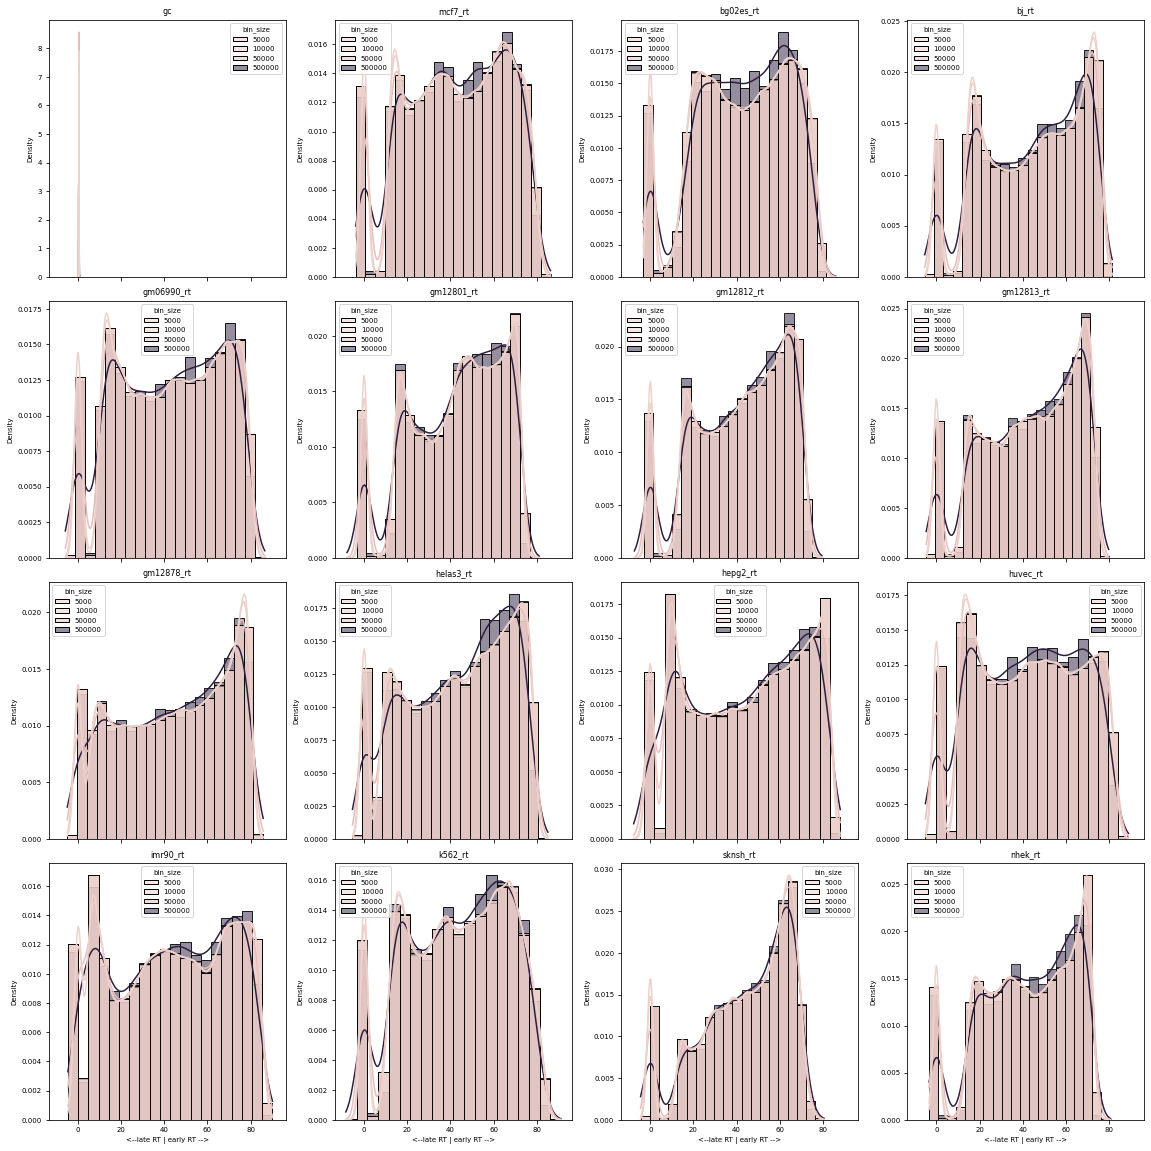

In [6]:
value_cols = [col for col in rt_bins.columns if col not in ['Chromosome', 'Start', 'End', 'bin_size']]

# create a grid of suplots (one for each value column) that shows the distribution of values with the bin size as the hue
num_cols = 4
num_rows = int(np.ceil(len(value_cols) / num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), tight_layout=True, sharex=True)
ax = ax.flatten()
for i, col in enumerate(value_cols):
    sns.histplot(data=rt_bins, x=col, hue='bin_size', bins=20, stat='density', kde=True, common_norm=False, ax=ax[i])
    ax[i].set_xlabel('<--late RT | early RT -->')
    ax[i].set_ylabel('Density')
    ax[i].set_title(col)
plt.show()

These results show that we often miss many late replicating regions of the genome when we use larger bin sizes. In general, these distributions match the loci RT distributions we see in the hTERT data where we find most loci to have early RT instead of late RT.

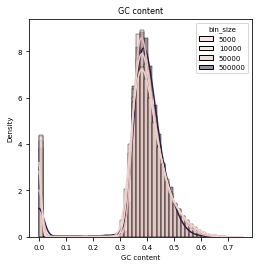

In [7]:
# show a histogram of just gc content at different bin sizes
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(data=rt_bins, x='gc', hue='bin_size', bins=50, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel('GC content')
ax.set_ylabel('Density')
ax.set_title('GC content')
plt.show()

In [8]:
# find the number of bins that have gc < 0.1 to see if they should be excluded from the analysis
rt_bins[rt_bins.gc < 0.1].head()

,Chromosome,Start,End,gc,mcf7_rt,bg02es_rt,bj_rt,gm06990_rt,gm12801_rt,gm12812_rt,gm12813_rt,gm12878_rt,helas3_rt,hepg2_rt,huvec_rt,imr90_rt,k562_rt,sknsh_rt,nhek_rt,bin_size
36,1,180000,185000,0.0,54.374733,56.803732,35.690841,54.930230,53.774293,51.982986,42.015266,58.557952,40.137102,65.766465,55.003362,49.855349,54.065491,60.832465,42.423497,5000
37,1,185000,190000,0.0,53.921170,56.049266,35.003830,54.260618,53.854011,51.326662,42.088686,59.090241,39.584927,65.215097,54.933583,49.193374,53.693243,59.732191,42.254202,5000
38,1,190000,195000,0.0,53.371754,55.158232,34.352926,53.494966,53.970133,50.583070,42.126319,59.589642,39.055447,64.523960,54.828402,48.543058,53.421280,58.497573,42.146467,5000
39,1,195000,200000,0.0,52.719078,54.131036,33.734102,52.633176,54.118883,49.751709,42.120917,60.049433,38.553746,63.689238,54.689329,47.904525,53.257571,57.131428,42.100561,5000
40,1,200000,205000,0.0,51.956876,52.969639,33.142021,51.675658,54.294863,48.832566,42.064491,60.462751,38.084232,62.708679,54.517378,47.276893,53.206568,55.638390,42.114568,5000


In [9]:
rt_bins.shape, rt_bins[rt_bins.gc > 0.0].shape

((977413, 20), (913795, 20))

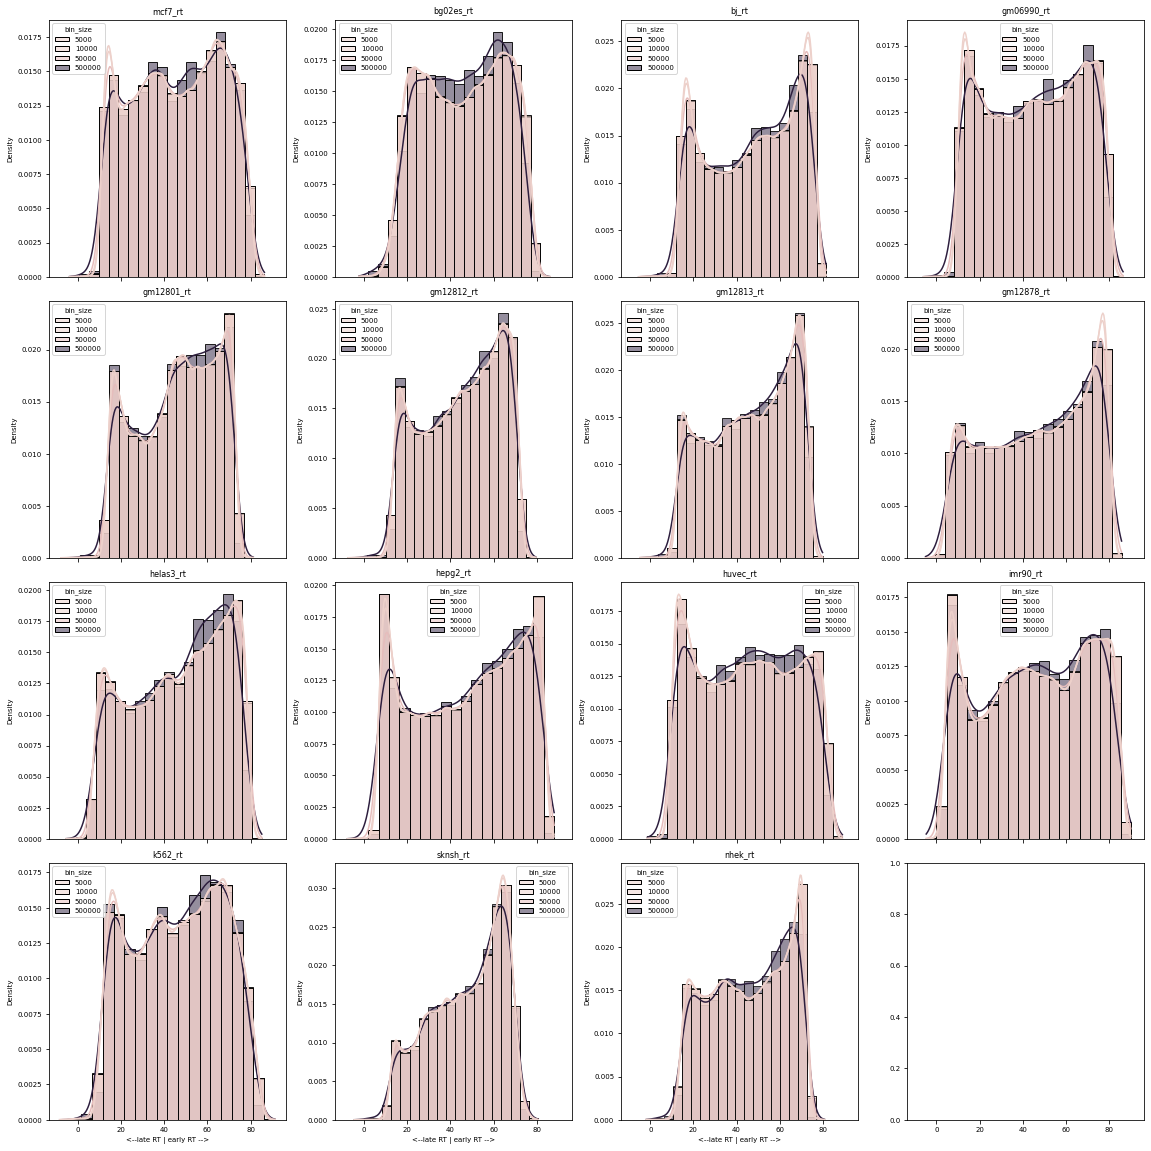

In [10]:
# remake the grid of RT value distributions but this time only include bins with gc>0.0
value_cols = [col for col in rt_bins.columns if col not in ['Chromosome', 'Start', 'End', 'bin_size', 'gc']]
rt_bins_no_zero_gc = rt_bins[rt_bins.gc > 0.0]

# create a grid of suplots (one for each value column) that shows the distribution of values with the bin size as the hue
num_cols = 4
num_rows = int(np.ceil(len(value_cols) / num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), tight_layout=True, sharex=True)
ax = ax.flatten()
for i, col in enumerate(value_cols):
    sns.histplot(data=rt_bins_no_zero_gc, x=col, hue='bin_size', bins=20, stat='density', kde=True, common_norm=False, ax=ax[i])
    ax[i].set_xlabel('<--late RT | early RT -->')
    ax[i].set_ylabel('Density')
    ax[i].set_title(col)
plt.show()

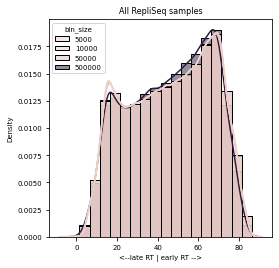

In [11]:
# plot all the rt values together in the same histogram that is still split by bin size

# melt the dataframe so that all the columns ending in '_rt' are in a new column noted as 'RT'
rt_bins_melted = rt_bins_no_zero_gc.melt(id_vars=['Chromosome', 'Start', 'End', 'bin_size', 'gc'], value_vars=[col for col in rt_bins_no_zero_gc.columns if col.endswith('_rt')], var_name='RT_source', value_name='RT')

fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(data=rt_bins_melted, x='RT', hue='bin_size', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel('<--late RT | early RT -->')
ax.set_ylabel('Density')
ax.set_title('All RepliSeq samples')
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


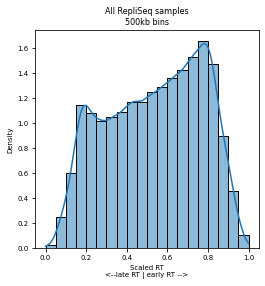

In [12]:
# plot the RT values of all RepliSeq samples for only 500kb bins and scale the x-axis values so that the min value is 0 and max is 1
rt_bins_melted_500kb = rt_bins_melted[rt_bins_melted.bin_size == 500000]
rt_bins_melted_500kb['RT_scaled'] = (rt_bins_melted_500kb.RT - rt_bins_melted_500kb.RT.min()) / (rt_bins_melted_500kb.RT.max() - rt_bins_melted_500kb.RT.min())

fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(data=rt_bins_melted_500kb, x='RT_scaled', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel('Scaled RT\n<--late RT | early RT -->')
ax.set_ylabel('Density')
ax.set_title('All RepliSeq samples\n500kb bins')
plt.show()

In [13]:
# load the RT data from SA039 to compare it to this distribution of RepliSeq data
rt_sa039 = pd.read_csv('../../analysis/sig_lines/SA039/scRT_pseudobulks.tsv', sep='\t', usecols=['chr', 'start', 'pseudobulk_model_rep_state'])
# change the column names and start positions for rt_sa039 so that can be merged with rt_bins_melted_500kb
rt_sa039 = rt_sa039.rename(columns={'chr': 'Chromosome', 'start': 'Start', 'pseudobulk_model_rep_state': 'SA039_rt'})
rt_sa039.Start = rt_sa039.Start - 1
rt_sa039.head()


,Chromosome,Start,SA039_cloneA_rt
0,1,1000000,0.944694
1,1,1500000,0.949178
2,1,2000000,0.955157
3,1,3000000,0.877429
4,1,4000000,0.765321


In [14]:
# merge the two dataframes together
rt_melted_merged_sa039 = rt_bins_melted_500kb.merge(rt_sa039, how='inner', on=['Chromosome', 'Start'])
rt_melted_merged_sa039.head()

,Chromosome,Start,End,bin_size,gc,RT_source,RT,RT_scaled,SA039_cloneA_rt
0,1,1000000,1500000,500000,0.59833,mcf7_rt,81.441980,0.948979,0.944694
1,1,1000000,1500000,500000,0.59833,bg02es_rt,74.182861,0.864410,0.944694
2,1,1000000,1500000,500000,0.59833,bj_rt,73.499876,0.856453,0.944694
3,1,1000000,1500000,500000,0.59833,gm06990_rt,78.515206,0.914882,0.944694
4,1,1000000,1500000,500000,0.59833,gm12801_rt,74.146042,0.863981,0.944694


In [15]:
# melt rt_melted_merged so that all the columns ending in '_rt' are in a new column noted as 'RT'
rt_melted_merged_sa039 = rt_melted_merged_sa039.melt(id_vars=['Chromosome', 'Start', 'End', 'bin_size', 'gc'], value_vars=[col for col in rt_melted_merged_sa039.columns if col.endswith('_rt')], var_name='RT_source', value_name='RT')

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  


In [16]:
# scale the RT values so that the min value is 0 and max is 1
rt_melted_merged_sa039['RT_scaled'] = (rt_melted_merged_sa039.RT - rt_melted_merged_sa039.RT.min()) / (rt_melted_merged_sa039.RT.max() - rt_melted_merged_sa039.RT.min())

# concatenate the RepliSeq and SA039 melted dataframes together, adding a column to denote which are from RepliSeq vs PERT before concatenating
rt_bins_melted_500kb['method'] = 'RepliSeq'
rt_melted_merged_sa039['method'] = 'PERT'
rt_melted_merged = pd.concat([rt_bins_melted_500kb, rt_melted_merged_sa039], ignore_index=True)
rt_melted_merged.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Chromosome,Start,End,bin_size,gc,RT_source,RT,RT_scaled,method
0,1,0,500000,500000,0.306414,mcf7_rt,38.977248,0.454265,RepliSeq
1,1,500000,1000000,500000,0.479984,mcf7_rt,69.653028,0.811638,RepliSeq
2,1,1000000,1500000,500000,0.598330,mcf7_rt,81.441980,0.948979,RepliSeq
3,1,1500000,2000000,500000,0.539496,mcf7_rt,79.131013,0.922056,RepliSeq
4,1,2000000,2500000,500000,0.594508,mcf7_rt,78.557313,0.915372,RepliSeq


In [17]:
rt_melted_merged.tail()

,Chromosome,Start,End,bin_size,gc,RT_source,RT,RT_scaled,method
167830,X,154500000,155000000,500000,0.384042,SA039_cloneA_rt,0.007474,0.007474,PERT
167831,X,154500000,155000000,500000,0.384042,SA039_cloneA_rt,0.007474,0.007474,PERT
167832,X,154500000,155000000,500000,0.384042,SA039_cloneA_rt,0.007474,0.007474,PERT
167833,X,154500000,155000000,500000,0.384042,SA039_cloneA_rt,0.007474,0.007474,PERT
167834,X,154500000,155000000,500000,0.384042,SA039_cloneA_rt,0.007474,0.007474,PERT


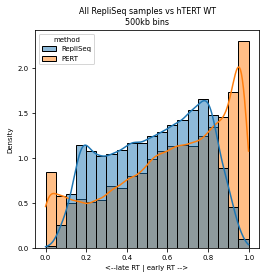

In [18]:
# plot a histogram of the RT values from RepliSeq and PERT for 500kb bins
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(data=rt_melted_merged, x='RT_scaled', hue='method', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel('<--late RT | early RT -->')
ax.set_ylabel('Density')
ax.set_title('All RepliSeq samples vs hTERT WT\n500kb bins')
plt.show()

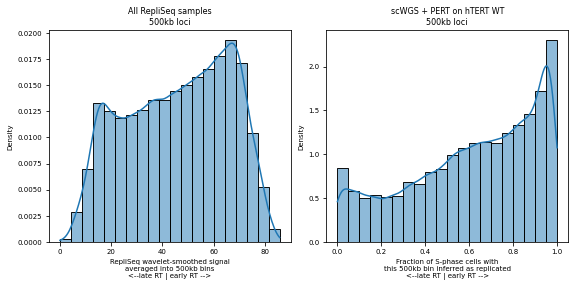

In [19]:
# create two subplots side by side that show the RT values from RepliSeq and PERT for 500kb bins
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
sns.histplot(data=rt_melted_merged[rt_melted_merged.method == 'RepliSeq'], x='RT', bins=20, stat='density', kde=True, common_norm=False, ax=ax[0])
ax[0].set_xlabel('RepliSeq wavelet-smoothed signal\naveraged into 500kb bins\n<--late RT | early RT -->')
ax[0].set_ylabel('Density')
ax[0].set_title('All RepliSeq samples\n500kb loci')

sns.histplot(data=rt_melted_merged[rt_melted_merged.method == 'PERT'], x='RT', bins=20, stat='density', kde=True, common_norm=False, ax=ax[1])
ax[1].set_xlabel('Fraction of S-phase cells with\nthis 500kb bin inferred as replicated\n<--late RT | early RT -->')
ax[1].set_ylabel('Density')
ax[1].set_title('scWGS + PERT on hTERT WT\n500kb loci')
plt.show()



In [20]:
rt_melted_merged.head()

,Chromosome,Start,End,bin_size,gc,RT_source,RT,RT_scaled,method
0,1,0,500000,500000,0.306414,mcf7_rt,38.977248,0.454265,RepliSeq
1,1,500000,1000000,500000,0.479984,mcf7_rt,69.653028,0.811638,RepliSeq
2,1,1000000,1500000,500000,0.598330,mcf7_rt,81.441980,0.948979,RepliSeq
3,1,1500000,2000000,500000,0.539496,mcf7_rt,79.131013,0.922056,RepliSeq
4,1,2000000,2500000,500000,0.594508,mcf7_rt,78.557313,0.915372,RepliSeq


In [21]:
# create a new dataframe that merges the RT values from chromosome, start, end and RT_scaled from both RepliSeq and PERT methods
rt_repliseq = rt_melted_merged[rt_melted_merged.method == 'RepliSeq'][['Chromosome', 'Start', 'End', 'RT', 'RT_source']]
# aggregate rt_repliseq by taking the mean across all RT_source values for each chromosome, start, end
rt_repliseq = rt_repliseq.groupby(['Chromosome', 'Start', 'End']).agg({'RT': 'mean'}).reset_index().drop_duplicates()
rt_pert = rt_melted_merged[rt_melted_merged.method == 'PERT'][['Chromosome', 'Start', 'End', 'RT']].drop_duplicates()
# rename the RT_scaled columns to RT_pert and RT_repliseq
rt_pert = rt_pert.rename(columns={'RT': 'RT_pert'})
rt_repliseq = rt_repliseq.rename(columns={'RT': 'RT_repliseq'})
# merge the two dataframes together
rt_merged = rt_pert.merge(rt_repliseq, how='inner', on=['Chromosome', 'Start', 'End'])
# remove chromosome X and Y from the dataframe
rt_merged = rt_merged[~rt_merged.Chromosome.isin(['Y'])]
rt_merged.head()

,Chromosome,Start,End,RT_pert,RT_repliseq
0,1,1000000,1500000,0.944694,77.464700
1,1,1500000,2000000,0.949178,76.120921
2,1,2000000,2500000,0.955157,72.414691
3,1,3000000,3500000,0.877429,51.503830
4,1,4000000,4500000,0.765321,38.804622


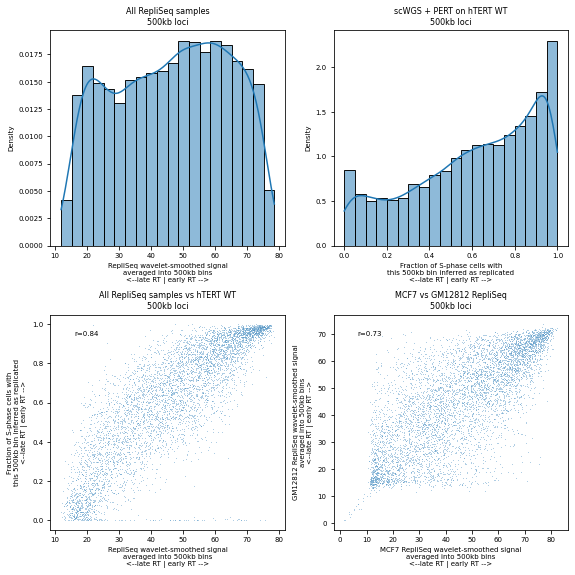

In [22]:
# create two subplots side by side that show the RT values from RepliSeq and PERT for 500kb bins
fig, ax = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
ax = ax.flatten()

sns.histplot(data=rt_merged, x='RT_repliseq', bins=20, stat='density', kde=True, common_norm=False, ax=ax[0])
ax[0].set_xlabel('RepliSeq wavelet-smoothed signal\naveraged into 500kb bins\n<--late RT | early RT -->')
ax[0].set_ylabel('Density')
ax[0].set_title('All RepliSeq samples\n500kb loci')

sns.histplot(data=rt_merged, x='RT_pert', bins=20, stat='density', kde=True, common_norm=False, ax=ax[1])
ax[1].set_xlabel('Fraction of S-phase cells with\nthis 500kb bin inferred as replicated\n<--late RT | early RT -->')
ax[1].set_ylabel('Density')
ax[1].set_title('scWGS + PERT on hTERT WT\n500kb loci')

sns.scatterplot(data=rt_merged, x='RT_repliseq', y='RT_pert', ax=ax[2], alpha=0.5, s=1)
ax[2].set_xlabel('RepliSeq wavelet-smoothed signal\naveraged into 500kb bins\n<--late RT | early RT -->')
ax[2].set_ylabel('Fraction of S-phase cells with\nthis 500kb bin inferred as replicated\n<--late RT | early RT -->')
ax[2].set_title('All RepliSeq samples vs hTERT WT\n500kb loci')
# compute the spearmans correlation between the two RT values and add it to the plot
r, p = stats.pearsonr(rt_merged.RT_repliseq, rt_merged.RT_pert)
# plot the first two digits of r
ax[2].text(0.1, 0.9, f'r={r:.2f}', transform=ax[2].transAxes)

# compute the correlation between two different RepliSeq samples to show that they are highly but not perfectly correlated
sns.scatterplot(data=rt_bins_no_zero_gc.query('bin_size == 500000'), x='mcf7_rt', y='gm12812_rt', ax=ax[3], alpha=0.5, s=1)
ax[3].set_xlabel('MCF7 RepliSeq wavelet-smoothed signal\naveraged into 500kb bins\n<--late RT | early RT -->')
ax[3].set_ylabel('GM12812 RepliSeq wavelet-smoothed signal\naveraged into 500kb bins\n<--late RT | early RT -->')
ax[3].set_title('MCF7 vs GM12812 RepliSeq\n500kb loci')
# compute the spearmans correlation between the two RT values and add it to the plot
r, p = stats.pearsonr(rt_bins_no_zero_gc.mcf7_rt, rt_bins_no_zero_gc.gm12812_rt)
# plot the first two digits of r
ax[3].text(0.1, 0.9, f'r={r:.2f}', transform=ax[3].transAxes)

plt.show()

In [23]:
rt_merged2 = pd.merge(rt_merged, rt_bins_no_zero_gc.query('bin_size == 500000'))
rt_merged2.shape, rt_merged2.columns

((5451, 22),
 Index(['Chromosome', 'Start', 'End', 'RT_pert', 'RT_repliseq', 'gc', 'mcf7_rt',
        'bg02es_rt', 'bj_rt', 'gm06990_rt', 'gm12801_rt', 'gm12812_rt',
        'gm12813_rt', 'gm12878_rt', 'helas3_rt', 'hepg2_rt', 'huvec_rt',
        'imr90_rt', 'k562_rt', 'sknsh_rt', 'nhek_rt', 'bin_size'],
       dtype='object'))

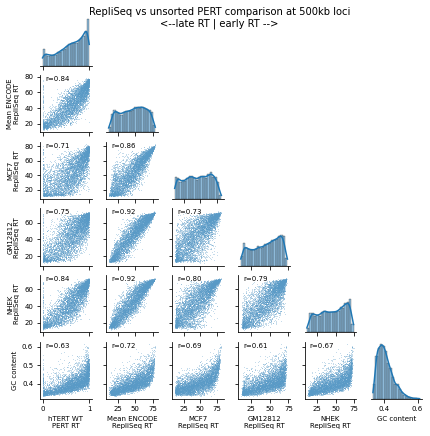

In [41]:
# create a pairgrid of scatterplots that show the RT values from RepliSeq and PERT for 500kb bins
vars = ['RT_pert', 'RT_repliseq', 'mcf7_rt', 'gm12812_rt', 'nhek_rt', 'gc']
g = sns.PairGrid(rt_merged2, vars=vars, corner=True, despine=True, height=1)
g.map_diag(sns.histplot, bins=20, kde=True)
g.map_lower(sns.scatterplot, alpha=0.5, s=0.7, rasterized=True)
# show the correlation coefficient between the two RT values in the upper triangle
for i in range(len(vars)):
    for j in range(len(vars)):
        if i > j:
            r, p = stats.pearsonr(rt_merged2.loc[:, vars[i]], rt_merged2.loc[:, vars[j]])
            g.axes[i, j].text(0.1, 0.9, f'r={r:.2f}', transform=g.axes[i, j].transAxes)

# rename the axis labels to be more descriptive according to the following dictionary of vars to labels
vars_to_labels = {'RT_pert': 'hTERT WT\nPERT RT', 'RT_repliseq': 'Mean ENCODE\nRepliSeq RT', 'mcf7_rt': 'MCF7\nRepliSeq RT', 'gm12812_rt': 'GM12812\nRepliSeq RT', 'nhek_rt': 'NHEK\nRepliSeq RT', 'gc': 'GC content'}
for i in range(len(vars)):
    g.axes[-1, i].set_xlabel(vars_to_labels[vars[i]])
    g.axes[i, 0].set_ylabel(vars_to_labels[vars[i]])

# add a super title to the figure
g.fig.suptitle('RepliSeq vs unsorted PERT comparison at 500kb loci\n<--late RT | early RT -->')

g.fig.savefig('../../manuscript/extended_data_figs/figED4.pdf', dpi=300, bbox_inches='tight')

plt.show()